# Transformer Model

This notebook instantiates a Transformer model, loads pre-trained weights and visualizes internal states by adding `hooks` to several attention layers to visualize results and store internal states

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from TransformerEncoder import TransformerEncoder
import torch
import tqdm
import pandas as pd

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

sns.set_style("whitegrid")

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

load data

In [3]:
X = np.load("data/x.npy")
y = np.load("data/y.npy")
meta = np.load("data/meta.npy")

x = X[0]
y[0]

fld=os.path.join("data/transformer")

df = pd.DataFrame(x, columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(fld,"x.csv"))

np.savetxt(fld+"/x.txt", x, fmt="%.4f")

loading model from transformer.pth


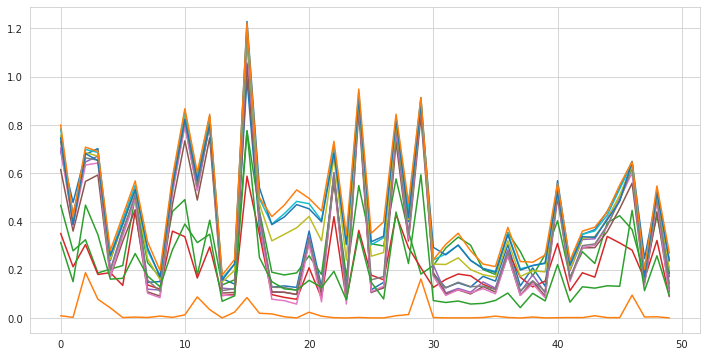

In [4]:
hidden_dims = 128
n_heads = 3
n_layers = 3
dropout=0.262039
d_inner = hidden_dims*4
nclasses=34

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

transformer.load("transformer.pth")
#transformer = transformer.cuda()

fix,ax = plt.subplots(1,figsize=(12,6))
ax.plot(x)
#ax.axis('off')

def totorch(x):
    """single numpy array (txd) to torch batch (1xdxt)"""
    x = torch.Tensor(x).unsqueeze(0).transpose(1,2)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

 14%|█▍        | 7/50 [00:00<00:00, 67.41it/s]

self-attention-1
writing data/transformer/enc_slf_attn_0.txt
writing data/transformer/enc_slf_attn_1.txt
writing data/transformer/enc_slf_attn_2.txt
writing data/transformer/enc_output.txt
writing data/transformer/enc_input.txt


 18%|█▊        | 9/50 [00:00<00:00, 89.09it/s]

writing data/transformer/self-attention-1.png
self-attention-2
writing data/transformer/enc_slf_attn_0.txt
writing data/transformer/enc_slf_attn_1.txt
writing data/transformer/enc_slf_attn_2.txt
writing data/transformer/enc_output.txt
writing data/transformer/enc_input.txt


 18%|█▊        | 9/50 [00:00<00:00, 88.34it/s]

writing data/transformer/self-attention-2.png
self-attention-3
writing data/transformer/enc_slf_attn_0.txt
writing data/transformer/enc_slf_attn_1.txt
writing data/transformer/enc_slf_attn_2.txt
writing data/transformer/enc_output.txt
writing data/transformer/enc_input.txt


100%|██████████| 50/50 [00:00<00:00, 70.65it/s]


writing data/transformer/self-attention-3.png
(34,)
writing data/transformer/outlinear.png


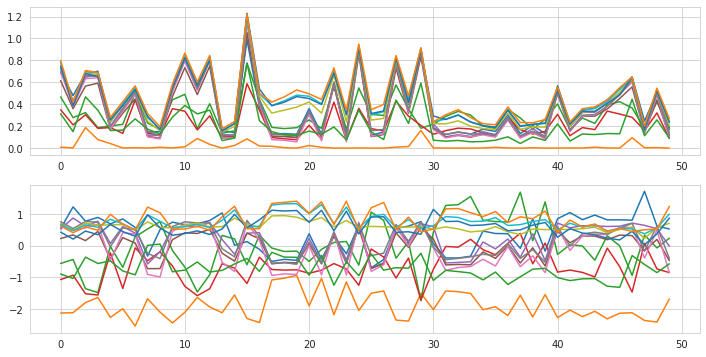

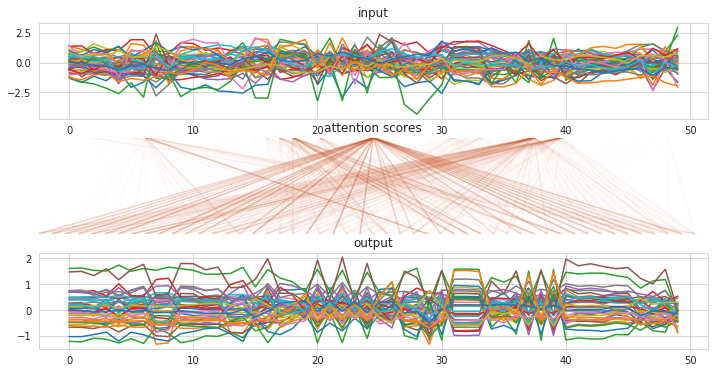

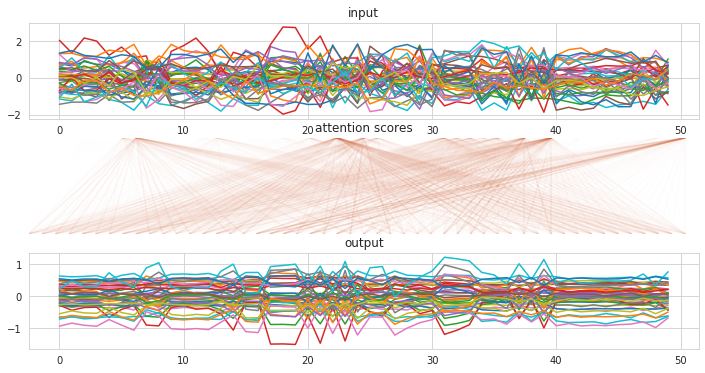

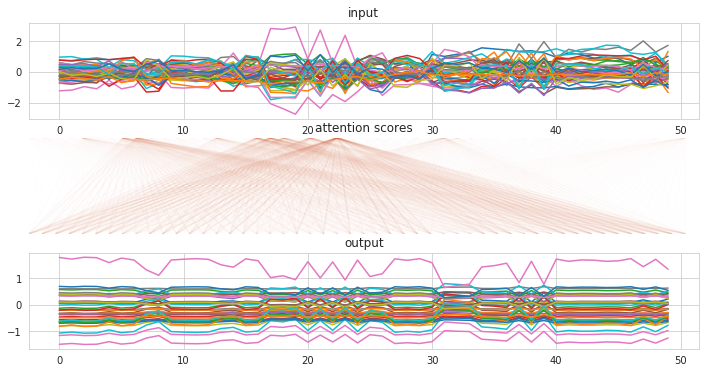

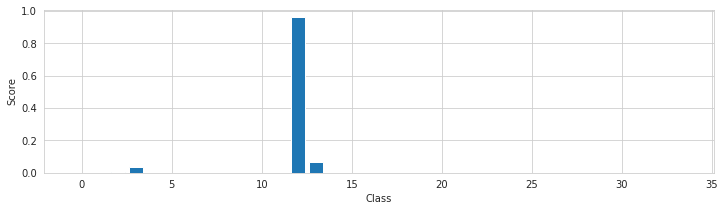

In [5]:
tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumred=(0.76862745,  0.28235294,  0.10588235,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumred[0],tumred[1],tumred[2],arr[o,i,0]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

def attention_hook(module, inp, out, name):
    print(name)
    
    enc_output, enc_slf_attn = out
    
    # Query, Key, Values <- all the same input for self-attention
    enc_input, enc_input, enc_input = inp
    
    os.makedirs(fld,exist_ok=True)
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt(fld+"/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
        print("writing "+fld+"/enc_slf_attn_{}.txt".format(i))
    np.savetxt(fld+"/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+fld+"/enc_output.txt")
    np.savetxt(fld+"/enc_input.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+fld+"/enc_input.txt")
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())
    
    fig.savefig(os.path.join(fld,name+".png"), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(fld,name+".png"))
    
def attention1_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-1")
    

def attention2_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-2")
    

def attention3_hook(module, inp, out):
    attention_hook(module, inp, out, name="self-attention-3")
    
    
def outlinear_hook(module, inp, out):
    inp = inp[0].cpu().detach().numpy()
    out = out[0].cpu().detach().numpy()
    print(out.shape)
    fig,ax = plt.subplots(1,figsize=(12,3))
    ax.bar(np.arange(out.shape[0]), np.exp(out))
    ax.set_ylabel("Score")
    ax.set_xlabel("Class")
    
    fig.savefig(os.path.join(fld,"outlinear.png"), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(fld,"outlinear.png"))
    
def inlayernorm_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
def pos_ffn_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
transformer.zero_grad()
transformer.eval()

transformer.inlayernorm.register_forward_hook(inlayernorm_hook)
transformer.encoder.layer_stack[0].slf_attn.attention.register_forward_hook(attention1_hook)
#transformer.encoder.layer_stack[0].pos_ffn.register_forward_hook(pos_ffn_hook)
transformer.encoder.layer_stack[1].slf_attn.attention.register_forward_hook(attention2_hook)
transformer.encoder.layer_stack[2].slf_attn.attention.register_forward_hook(attention3_hook)
transformer.outlinear.register_forward_hook(outlinear_hook)

logprobabilities = transformer.forward(totorch(x))
probas = torch.exp(logprobabilities)


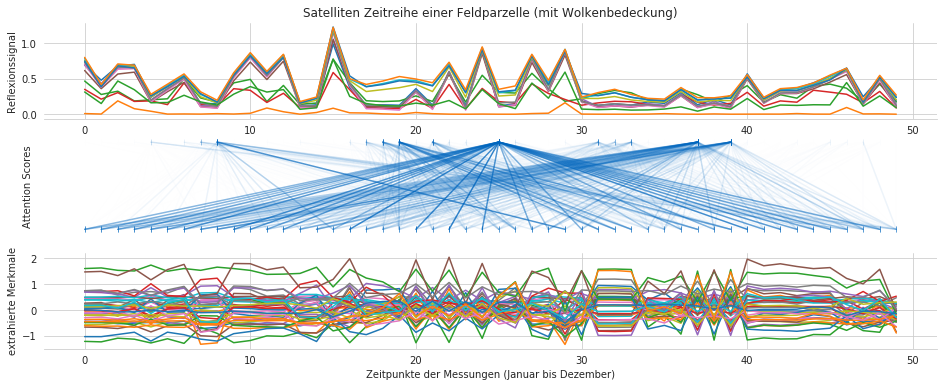

In [6]:
from matplotlib import cm

path = "/tmp"

def plot_attention(path, head=0):

    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))
    enc_output = np.loadtxt(path+"/enc_output.txt")

    fig, axs = plt.subplots(3,figsize=(16,6))
    sns.despine(ax=axs[0], left=True)
    #sns.despine(ax=axs[1])
    sns.despine(ax=axs[2], left=True)

    axs[0].plot(x)
    axs[0].set_title("Satelliten Zeitreihe einer Feldparzelle (mit Wolkenbedeckung)")
    axs[0].set_ylabel("Reflexionssignal")
    for o in range(arr0.shape[1]):
        for i in range(arr0.shape[0]):
            axs[1].set_xlim(*axs[0].get_xlim())
            axs[1].set_ylim(-.05,1.05)
            axs[1].add_line(Line2D([i,o], [1,0],marker='|',color=(tumblue[0],tumblue[1],tumblue[2],arr0[o,i])))
            #axs[1].plot([i,o], [1,0],'r', alpha=arr0[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'g', alpha=arr1[o,i]*0.5)
            #axs[1].plot([i,o], [1,0],'b', alpha=arr2[o,i]*0.5)
    #axs[1].axis('off')
    axs[1].set_yticklabels([])
    axs[1].set_xticklabels([])
    axs[1].set_ylabel("Attention Scores")
    axs[1].set_frame_on(False)
    axs[1].grid(False)

    axs[2].plot(enc_output)
    axs[2].set_ylabel("extrahierte Merkmale")
    axs[2].set_xlabel("Zeitpunkte der Messungen (Januar bis Dezember)")

    fig.savefig("/tmp/attention.png", dpi=300)

plot_attention("data/transformer/self-attention-1")

writing data/transformer/self-attention-1/head0_imshow.png
writing data/transformer/self-attention-1/head0_imshow.png
writing data/transformer/self-attention-1/head0_imshow.png


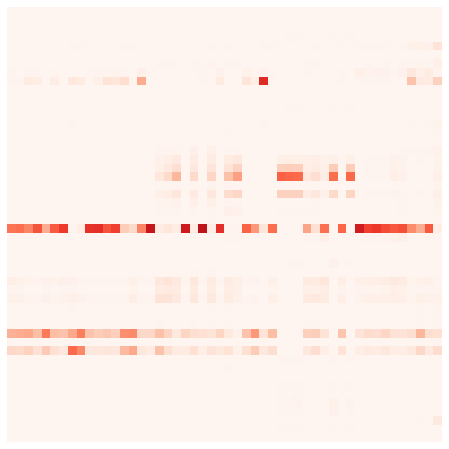

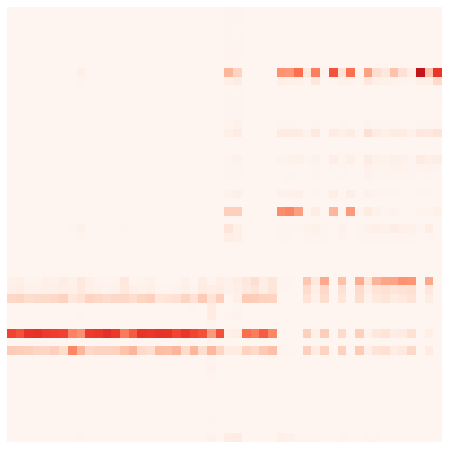

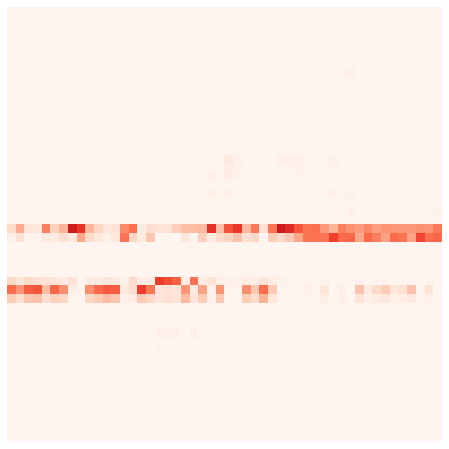

In [7]:
path="data/transformer/self-attention-1"
head=0

for head in [0,1,2]:
    arr0 = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    s = ax.imshow(arr0.T, cmap="Reds", vmin=0, vmax=1)
    ax.axis('off')
    fig.savefig(os.path.join(path,"head{}_imshow.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head0_imshow.png"))
    #fig.colorbar(s)

  4%|▍         | 2/50 [00:00<00:02, 19.72it/s]

writing data/transformer/self-attention-1/head0_conn.png


  4%|▍         | 2/50 [00:00<00:03, 13.07it/s]

writing data/transformer/self-attention-1/head1_conn.png


100%|██████████| 50/50 [00:00<00:00, 40.20it/s]


writing data/transformer/self-attention-1/head2_conn.png


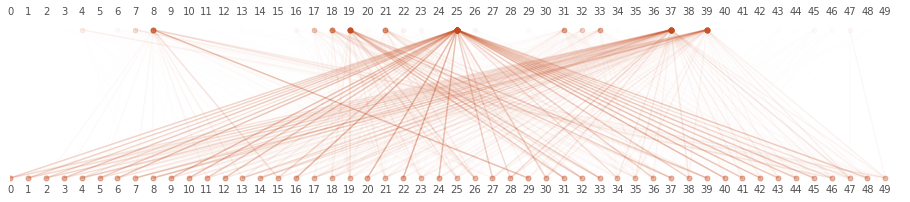

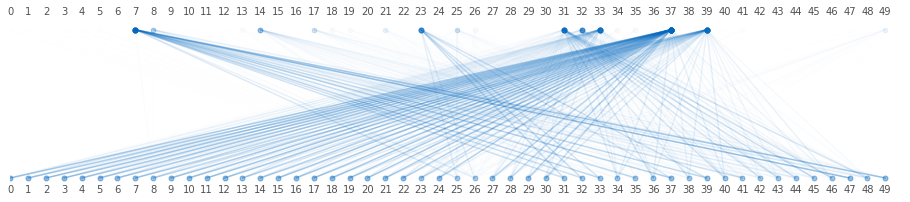

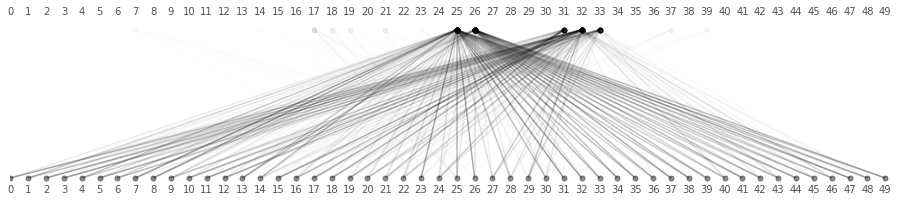

In [8]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, ax = plt.subplots(1, figsize=(16,3))
    N = arr.shape[0]
    ax.set_xlim(0,N)
    
    for t in range(N):
        ax.text(t,1.1,str(t),alpha=0.8, ha='center')
        ax.text(t,-.1,str(t),alpha=0.8, ha='center')
    
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
    ax.axis('off')

    fig.savefig(os.path.join(path,"head{}_conn.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head{}_conn.png".format(head)))

 14%|█▍        | 7/50 [00:00<00:01, 40.95it/s]

writing data/transformer/self-attention-1/head0_conn_input.png


  0%|          | 0/50 [00:00<?, ?it/s]

writing data/transformer/self-attention-1/head1_conn_input.png


100%|██████████| 50/50 [00:00<00:00, 51.99it/s]


writing data/transformer/self-attention-1/head2_conn_input.png


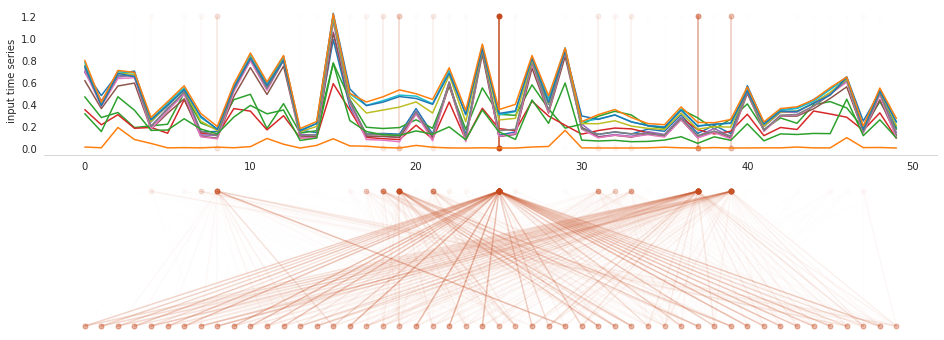

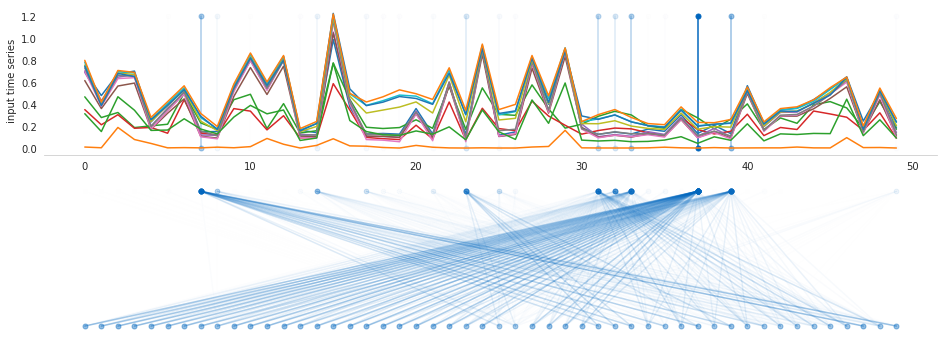

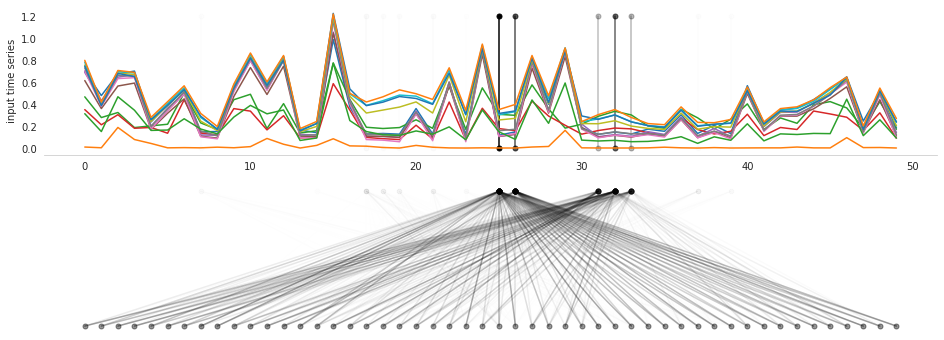

In [9]:
arr = arr0.T

color=tumred
for head, color in zip([0,1,2],[tumred, tumblue, tumblack]):
    arr = np.loadtxt(path+"/enc_slf_attn_{}.txt".format(head))

    fig, axs = plt.subplots(2, figsize=(16,6))
    input_focus = arr.sum(0)
    input_focus /= input_focus.max()
    for i in range(len(input_focus)):
        #axs[0].axvline(i, color=(color[0],color[1],color[2],input_focus[i]))
        line=Line2D([i,i], [0,1.2] ,marker='o', markersize=5,color=(color[0],color[1],color[2],input_focus[i]))
        axs[0].add_line(line)
    
    sns.despine(ax=axs[0], left=True)
    axs[0].plot(x)
    axs[0].grid(False)
    axs[0].set_ylabel("input time series")
 
    ax = axs[1]
    ax.set_xlim(*axs[0].get_xlim())
    N = arr.shape[0]
    #ax.set_ylabel("attention scores")
    #ax.set_xlim(0,N)
    for o in tqdm.tqdm(range(N)):
        for i in range(N):
            
            ax.set_ylim(-.05,1.05)
            ax.add_line(Line2D([i,o], [1,0],marker='o', markersize=5,color=(color[0],color[1],color[2],arr[o,i]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
            #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
    ax.axis('off')

    fig.savefig(os.path.join(path,"head{}_conn_input.png".format(head)), bbox_inches='tight', transparent=True)
    print("writing "+os.path.join(path,"head{}_conn_input.png".format(head)))

In [12]:
pd.DataFrame(x, columns=BANDS)

(50, 13)

array([1.10000e-03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e-03,
       0.00000e+00, 7.00000e-04, 1.23700e-01, 1.00000e-04, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e-04, 3.20000e-02,
       2.20000e-03, 3.30000e-03, 3.19000e-01, 2.15300e-01, 2.21800e-01,
       1.60000e-03, 2.62700e-01, 6.50000e-03, 9.80000e-02, 3.00000e-04,
       1.71797e+01, 1.15094e+01, 1.90000e-03, 3.70000e-03, 1.00000e-04,
       5.70000e-03, 4.38350e+00, 1.04605e+01, 4.84500e+00, 1.40000e-03,
       1.00000e-03, 2.50000e-03, 1.89200e-01, 0.00000e+00, 1.19400e-01,
       1.00000e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       4.00000e-04, 2.00000e-04, 0.00000e+00, 1.00000e-04, 0.00000e+00])